Importing relevant packages

In [ ]:
import keras
import keras.backend as K
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
%matplotlib inline

Loading train, test and rul csv files as dataframes to be processed

In [ ]:
train_2= pd.read_csv("/content/drive/MyDrive/CAPSTONE CODES WEISHENG/CMAPSSData/train_FD002.txt" ,sep=" ",header=None)
train_2.drop(columns=[26,27],inplace=True)

In [ ]:
test_2= pd.read_csv("/content/drive/MyDrive/CAPSTONE CODES WEISHENG/CMAPSSData/test_FD002.txt",sep=" ",header=None)
test_2.drop(columns=[26,27],inplace=True)

In [ ]:
rul_2= pd.read_csv("/content/drive/MyDrive/CAPSTONE CODES WEISHENG/CMAPSSData/RUL_FD002.txt",sep=" ",header=None)
rul_2.drop(columns=[1],inplace=True)

In [ ]:
columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [ ]:
train_2.columns = columns
test_2.columns = columns

In [ ]:
description = train_2.describe()
description.loc['std']

id           74.463862
cycle        69.180569
setting1     14.747376
setting2      0.310016
setting3     14.237735
s1           26.389707
s2           37.289399
s3          105.946341
s4          119.123428
s5            3.613839
s6            5.431802
s7          146.005306
s8          145.209816
s9          335.812013
s10           0.127469
s11           3.232372
s12         137.659507
s13         128.068271
s14          84.837950
s15           0.749335
s16           0.004711
s17          27.754515
s18         145.327980
s19           5.364067
s20           9.869331
s21           5.921615
Name: std, dtype: float64

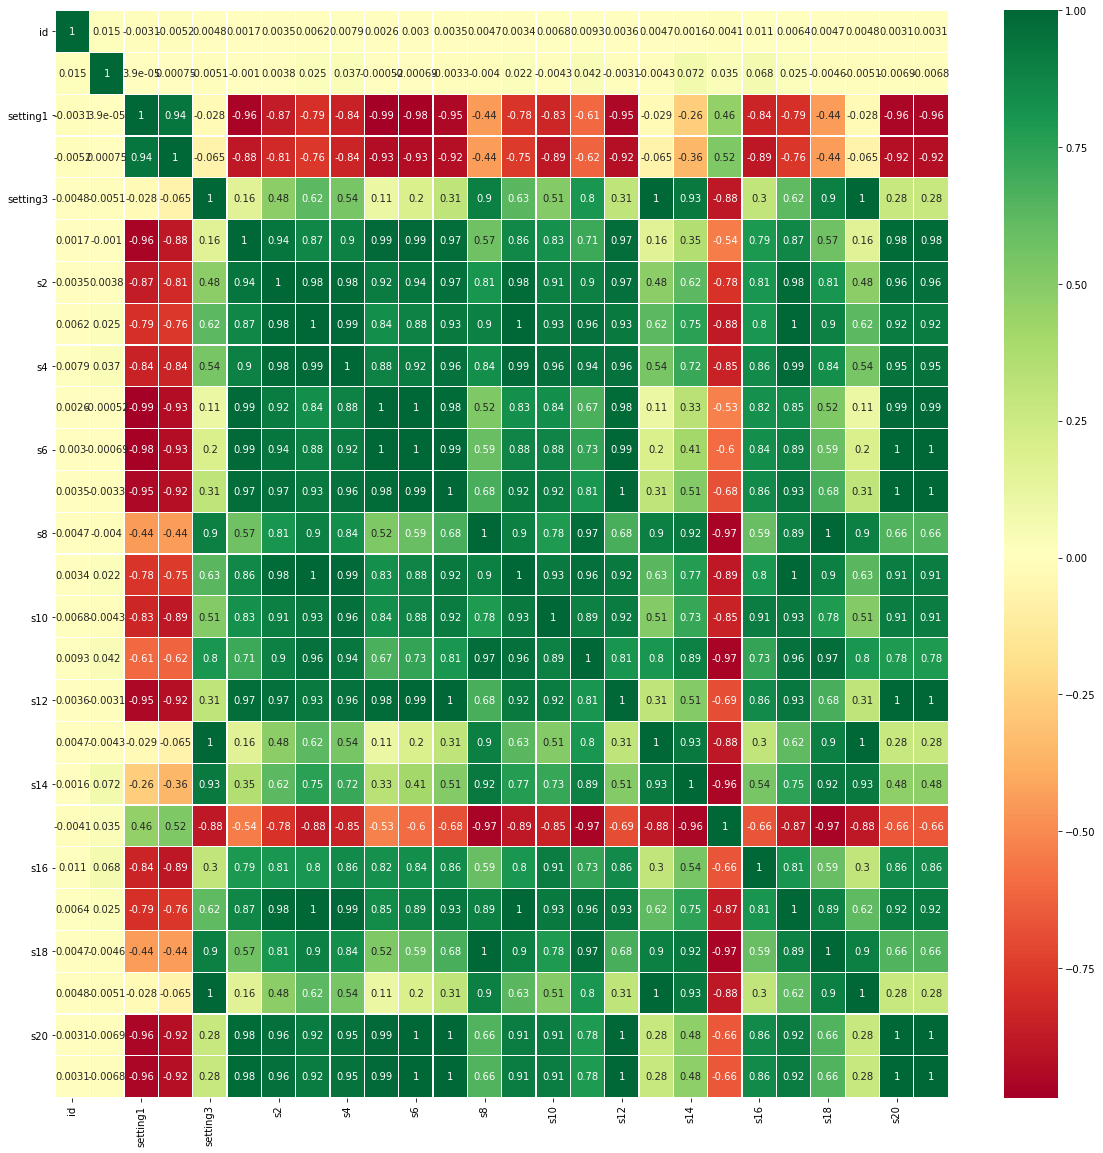

In [ ]:
sns.heatmap(train_2.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(20,20)
plt.show()

In [ ]:
#delete columns with constant values that do not carry information about the state of the unit
# train_2.drop(columns=['s16', 's19','s18','s17','s10','s5','s1','setting3','setting1','setting2'],inplace=True)

Investigate and remove columns/features that have constant standard deviation values as they do not carry information about the state of the unit

In [ ]:
description = train_2.describe()
description.loc['std']

id           74.463862
cycle        69.180569
setting1     14.747376
setting2      0.310016
setting3     14.237735
s1           26.389707
s2           37.289399
s3          105.946341
s4          119.123428
s5            3.613839
s6            5.431802
s7          146.005306
s8          145.209816
s9          335.812013
s10           0.127469
s11           3.232372
s12         137.659507
s13         128.068271
s14          84.837950
s15           0.749335
s16           0.004711
s17          27.754515
s18         145.327980
s19           5.364067
s20           9.869331
s21           5.921615
Name: std, dtype: float64

Data Pre-processing

In [ ]:
def prepare_train_data(data, factor = 0):
    df = data.copy()
    fd_RUL = df.groupby('id')['cycle'].max().reset_index()
    fd_RUL = pd.DataFrame(fd_RUL)
    fd_RUL.columns = ['id','max']
    df = df.merge(fd_RUL, on=['id'], how='left')
    df['RUL'] = df['max'] - df['cycle']
    df.drop(columns=['max'],inplace = True)
    return df[df['cycle'] > factor]

train_2 = prepare_train_data(train_2)    

In [ ]:
# MinMax normalization (from 0 to 1) train set
train_2['cycle_norm'] = train_2['cycle']
cols_normalize = train_2.columns.difference(['id','cycle','RUL'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_2 = pd.DataFrame(min_max_scaler.fit_transform(train_2[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_2.index)
join_df = train_2[train_2.columns.difference(cols_normalize)].join(norm_train_2)
train_2 = join_df.reindex(columns = train_2.columns)

# MinMax normalization (from 0 to 1) test set
test_2['cycle_norm'] = test_2['cycle']
norm_test_2 = pd.DataFrame(min_max_scaler.transform(test_2[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_2.index)
test_join_df = test_2[test_2.columns.difference(cols_normalize)].join(norm_test_2)
test_2 = test_join_df.reindex(columns = test_2.columns)
test_2 = test_2.reset_index(drop=True)
print(test_2.head())

# We use the ground truth dataset to generate labels for the test data.
# generate column max for test data
rul = pd.DataFrame(test_2.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
rul_2.columns = ['more']
rul_2['id'] = rul_2.index + 1
rul_2['max'] = rul['max'] + rul_2['more']
rul_2.drop('more', axis=1, inplace=True)

# generate RUL for test data
test_2 = test_2.merge(rul_2, on=['id'], how='left')
test_2['RUL'] = test_2['max'] - test_2['cycle']
test_2.drop('max', axis=1, inplace=True)

   id  cycle  setting1  setting2  ...  s19       s20       s21  cycle_norm
0   1      1  0.238019  0.297150  ...  1.0  0.625514  0.633951    0.000000
1   1      2  0.476162  0.831354  ...  1.0  0.483882  0.500205    0.002653
2   1      3  0.833282  0.997625  ...  1.0  0.164609  0.165078    0.005305
3   1      4  0.999967  0.998812  ...  1.0  0.005830  0.023186    0.007958
4   1      5  0.595089  0.737886  ...  0.0  0.141632  0.145822    0.010610

[5 rows x 27 columns]


In [ ]:
sequence_length = 50

In [ ]:
test_2.columns

Index(['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
       's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
       's15', 's16', 's17', 's18', 's19', 's20', 's21', 'cycle_norm', 'RUL'],
      dtype='object')

In [ ]:
# preparing data for visualizations 
# window of 50 cycles prior to a failure point for engine id 3
engine_id3 = test_2[test_2['id'] == 3]
engine_id3_50cycleWindow = engine_id3[engine_id3['RUL'] <= engine_id3['RUL'].min() + 50]
cols1 = ['setting1', 'setting2', 'setting3', 's1', 's2', 's3',
       's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
       's15', 's16', 's17', 's18', 's19', 's20', 's21']
engine_id3_50cycleWindow1 = engine_id3_50cycleWindow[cols1]


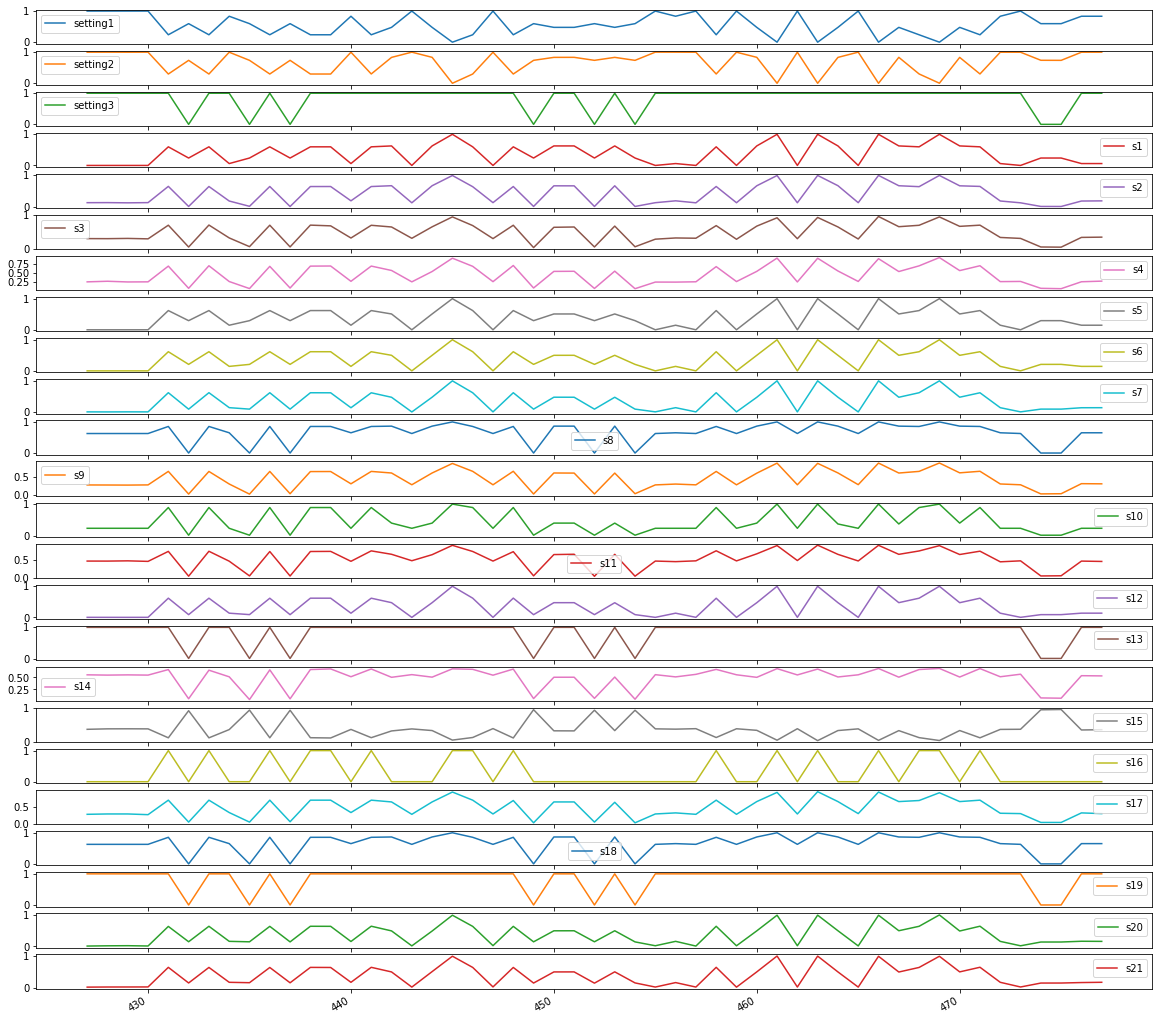

In [ ]:
# plotting sensor data for engine ID 3 prior to a failure point - sensors 1-10 
ax1 = engine_id3_50cycleWindow1.plot(subplots=True, sharex=True, figsize=(20,20))

In [ ]:
# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

In [ ]:
# pick the feature columns 
sequence_cols = ['cycle_norm','setting1', 'setting2', 'setting3', 's1', 's2', 's3',
       's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
       's15', 's16', 's17', 's18', 's19', 's20', 's21']

seq_gen = (list(gen_sequence(train_2[train_2['id']==id], sequence_length, sequence_cols)) 
           for id in train_2['id'].unique())

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

(40759, 50, 25)

In [ ]:
def gen_labels(id_df, seq_length, label):
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    return data_matrix[seq_length:num_elements, :]

In [ ]:
# generate labels
label_gen = [gen_labels(train_2[train_2['id']==id], sequence_length, ['RUL']) 
             for id in train_2['id'].unique()]

label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(40759, 1)

In [ ]:
def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

LSTM, BASE MODEL


In [ ]:
# build the network
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

lstm_model = Sequential()

lstm_model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=300,
         return_sequences=True))
lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(
          units=150,
          return_sequences=False))
lstm_model.add(Dropout(0.2))

lstm_model.add(Dense(units=nb_out, activation='linear'))
lstm_model.compile(loss='mean_squared_error', optimizer='Adam', metrics=['mse',r2_keras])

lstm_model.summary()

# optimizer='rmsprop'

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50, 300)           391200    
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 300)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 150)               270600    
_________________________________________________________________
dropout_3 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 151       
Total params: 661,951
Trainable params: 661,951
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
# define path to save model

bst_model_path = 'lstm_dataset2' + '.h5'
model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=False)

In [ ]:
%%time
# fit the network
lstm_model.fit(seq_array, label_array, epochs=300, batch_size=32, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=30, verbose=0, mode='min')])

Epoch 1/300
1211/1211 [==============================] - 14s 10ms/step - loss: 5109.1593 - mse: 5109.1593 - r2_keras: -72513.4615 - val_loss: 5227.5850 - val_mse: 5227.5850 - val_r2_keras: -47.1431
Epoch 2/300
1211/1211 [==============================] - 11s 9ms/step - loss: 3261.8115 - mse: 3261.8115 - r2_keras: -4070.2671 - val_loss: 5281.4580 - val_mse: 5281.4580 - val_r2_keras: -47.7605
Epoch 3/300
1211/1211 [==============================] - 11s 9ms/step - loss: 3186.3515 - mse: 3186.3515 - r2_keras: -65048.3182 - val_loss: 5225.6899 - val_mse: 5225.6899 - val_r2_keras: -47.1212
Epoch 4/300
1211/1211 [==============================] - 11s 9ms/step - loss: 3236.2443 - mse: 3236.2443 - r2_keras: -11821.6319 - val_loss: 5234.4336 - val_mse: 5234.4336 - val_r2_keras: -47.2220
Epoch 5/300
1211/1211 [==============================] - 11s 9ms/step - loss: 3220.6139 - mse: 3220.6139 - r2_keras: -4000.7250 - val_loss: 5276.0508 - val_mse: 5276.0508 - val_r2_keras: -47.6988
Epoch 6/300
1211

In [ ]:
# training metrics
scores = lstm_model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('\nMSE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))
rmse = np.sqrt(scores[1])
print("RMSE: %f" % (rmse))

204/204 [==============================] - 2s 9ms/step - loss: 152.3570 - mse: 152.3570 - r2_keras: 0.9541

MSE: 152.35704040527344

R^2: 0.9540647864341736
RMSE: 12.343299


In [ ]:
seq_array_test_last = [test_2[test_2['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_2['id'].unique() if len(test_2[test_2['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
seq_array_test_last.shape

(235, 50, 25)

In [ ]:
y_mask = [len(test_2[test_2['id']==id]) >= sequence_length for id in test_2['id'].unique()]
label_array_test_last = test_2.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)

In [ ]:
scores_test = lstm_model.evaluate(seq_array_test_last, label_array_test_last, verbose = 1, batch_size = 200)
print('\nMSE: ' + str(scores_test[1]))
print('\nR^2: {}'.format(scores_test[2]))
rmse = np.sqrt(scores_test[1])
print("RMSE: %f" % (rmse))

2/2 [==============================] - 0s 8ms/step - loss: 850.5232 - mse: 850.5232 - r2_keras: 0.6965

MSE: 850.523193359375

R^2: 0.6965349912643433
RMSE: 29.163731


In [ ]:
## Use XGBoost 
import xgboost as xgb
import matplotlib.pyplot as plt  
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns

# Initialize Model
xgb_model = xgb.XGBRegressor(colsample_bytree = 0.5, learning_rate = 0.2,
                max_depth = 6, alpha = 10, n_estimators = 150)

# Train Test Split
X_train = seq_array.reshape(40759, 1250)
y_train = label_array
X_test = seq_array_test_last.reshape(235, 1250)
y_test = label_array_test_last

# Model Fitting on Data
xgb_model.fit(X_train, y_train)

# Get Predictions
y_pred = xgb_model.predict(X_test)

from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))


[05:55:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 26.747919


In [ ]:
# from sklearn.metrics import mean_squared_error
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# print("RMSE: %f" % (rmse))

In [ ]:
# X_test = xgb_model.predict(seq_array_test_last.reshape(235, 1250))
# rmse = np.sqrt(mean_squared_error(X_test, label_array_test_last))
# print("RMSE: %f" % (rmse))

#Without train test split


In [ ]:
seq_array_test_last.shape

(235, 50, 25)

MLP

In [ ]:
# mlp for Regression
from pandas import read_csv
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from numpy import sqrt

In [ ]:
# define model
mlp_model = Sequential()
mlp_model.add(Dense(64, activation='relu', kernel_initializer='he_normal', input_shape=(nb_features * 50,)))
mlp_model.add(Dense(32, activation='relu', kernel_initializer='he_normal'))
mlp_model.add(Dense(16, activation='relu', kernel_initializer='he_normal'))
mlp_model.add(Dense(8, activation='relu', kernel_initializer='he_normal'))
mlp_model.add(Dense(4, activation='relu', kernel_initializer='he_normal'))
mlp_model.add(Dense(1))
print(mlp_model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 64)                80064     
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_10 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_11 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_12 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 5         
Total params: 82,849
Trainable params: 82,849
Non-trainable params: 0
__________________________________________________

In [ ]:
# compile the model
mlp_model.compile(optimizer='rmsprop', loss='mse', metrics=['mse',r2_keras])

In [ ]:
# fit the model
mlp_model.fit(seq_array.reshape(40759, 1250), label_array, epochs=300, batch_size=32, validation_split=0.2, verbose=1,
              callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=30, verbose=0, mode='auto')])

Epoch 1/300
1019/1019 [==============================] - 4s 4ms/step - loss: 10505.8332 - mse: 10505.8332 - r2_keras: -2.4076 - val_loss: 10135.3203 - val_mse: 10135.3203 - val_r2_keras: -94.8269
Epoch 2/300
1019/1019 [==============================] - 4s 3ms/step - loss: 8637.5420 - mse: 8637.5420 - r2_keras: -1.7556 - val_loss: 2131.7500 - val_mse: 2131.7500 - val_r2_keras: -20.2428
Epoch 3/300
1019/1019 [==============================] - 3s 3ms/step - loss: 1930.3617 - mse: 1930.3617 - r2_keras: 0.3835 - val_loss: 1933.3339 - val_mse: 1933.3339 - val_r2_keras: -18.0414
Epoch 4/300
1019/1019 [==============================] - 4s 3ms/step - loss: 1929.1588 - mse: 1929.1588 - r2_keras: 0.3953 - val_loss: 1814.2190 - val_mse: 1814.2190 - val_r2_keras: -16.5193
Epoch 5/300
1019/1019 [==============================] - 3s 3ms/step - loss: 1856.5897 - mse: 1856.5897 - r2_keras: 0.4165 - val_loss: 2118.3718 - val_mse: 2118.3718 - val_r2_keras: -20.9691
Epoch 6/300
1019/1019 [================

In [ ]:
# training metrics
scores = mlp_model.evaluate(seq_array.reshape(40759, 1250), label_array, verbose=1, batch_size=200)
print('\nMSE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))
rmse = np.sqrt(scores[1])
print("RMSE: %f" % (rmse))

204/204 [==============================] - 0s 2ms/step - loss: 1081.0742 - mse: 1081.0742 - r2_keras: 0.5935

MSE: 1081.07421875

R^2: 0.5935236215591431
RMSE: 32.879693


In [ ]:
seq_array_test_last.shape

(235, 50, 25)

In [ ]:
# test metrics
scores_test = mlp_model.evaluate(seq_array_test_last.reshape(235, 1250), label_array_test_last, verbose=1, batch_size=200)
print('\nMSE: {}'.format(scores_test[1]))
print('\nR^2: {}'.format(scores_test[2]))
rmse = np.sqrt(scores_test[1])
print("RMSE: %f" % (rmse))

2/2 [==============================] - 0s 3ms/step - loss: 817.1487 - mse: 817.1487 - r2_keras: 0.6910

MSE: 817.1487426757812

R^2: 0.69098961353302
RMSE: 28.585814


STATE OF ART METHOD

In [ ]:
from keras.models import Sequential, Model
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM, GRU, SimpleRNN
from keras.layers import Input
from keras.utils.data_utils import get_file
from keras.optimizers import Nadam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers.normalization import BatchNormalization
from collections import Counter
import numpy as np
import random
import sys
import os
import copy
import csv
import time
from datetime import datetime
from math import log

In [ ]:
# build the model: 

main_input = Input(shape=(sequence_length, nb_features), name='main_input')
# train a 2-layer LSTM with one shared layer
l1 = LSTM(100, implementation=2, kernel_initializer='glorot_uniform', return_sequences=True, dropout=0.2)(main_input) # the shared layer
b1 = BatchNormalization()(l1)
l2_1 = LSTM(100, implementation=2, kernel_initializer='glorot_uniform', return_sequences=False, dropout=0.2)(b1) # the layer specialized in activity prediction
b2_1 = BatchNormalization()(l2_1)
l2_2 = LSTM(100, implementation=2, kernel_initializer='glorot_uniform', return_sequences=False, dropout=0.2)(b1) # the layer specialized in time prediction
b2_2 = BatchNormalization()(l2_2)
act_output = Dense(50, activation='linear', kernel_initializer='glorot_uniform', name='act_output')(b2_1)
time_output = Dense(1, kernel_initializer='glorot_uniform', name='time_output')(b2_2)

model = Model(inputs=[main_input], outputs=[act_output, time_output])
print(model.summary())

In [ ]:
seq_array.shape

(40759, 50, 25)

In [ ]:
label_array.shape

(40759, 1)

In [ ]:
opt = Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004, clipvalue=3)
model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mse',r2_keras])
early_stopping = EarlyStopping(monitor='val_loss', patience=30)
model_checkpoint = ModelCheckpoint('output_files/models/model_{epoch:02d}-{val_loss:.2f}.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto')
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

model.fit(seq_array, label_array, validation_split=0.2, verbose=2, callbacks=[early_stopping, model_checkpoint, lr_reducer], batch_size=32, epochs=500)

Epoch 1/500
1019/1019 - 19s - loss: 10456.1309 - act_output_loss: 5406.5957 - time_output_loss: 5049.5469 - act_output_mse: 5406.5957 - act_output_r2_keras: -8.6528e+01 - time_output_mse: 5049.5469 - time_output_r2_keras: -6.3509e-01 - val_loss: 3641.2224 - val_act_output_loss: 1817.0750 - val_time_output_loss: 1824.1472 - val_act_output_mse: 1817.0750 - val_act_output_r2_keras: -9.1882e+02 - val_time_output_mse: 1824.1472 - val_time_output_r2_keras: -1.6958e+01
Epoch 2/500
1019/1019 - 14s - loss: 3401.7974 - act_output_loss: 1700.2833 - time_output_loss: 1701.5094 - act_output_mse: 1700.2833 - act_output_r2_keras: -2.5844e+01 - time_output_mse: 1701.5094 - time_output_r2_keras: 0.4626 - val_loss: 3120.5767 - val_act_output_loss: 1603.6473 - val_time_output_loss: 1516.9280 - val_act_output_mse: 1603.6473 - val_act_output_r2_keras: -7.9979e+02 - val_time_output_mse: 1516.9280 - val_time_output_r2_keras: -1.4180e+01
Epoch 3/500
1019/1019 - 14s - loss: 3185.3596 - act_output_loss: 1595.01

In [ ]:
scores_test = model.evaluate(seq_array_test_last, label_array_test_last, verbose = 1, batch_size = 200)
print('\nMSE: ' + str(scores_test[1]))
print('\nR^2: {}'.format(scores_test[2]))
rmse = np.sqrt(scores_test[1])
print("RMSE: %f" % (rmse))

2/2 [==============================] - 0s 11ms/step - loss: 9459.7812 - act_output_loss: 5025.7363 - time_output_loss: 4434.0454 - act_output_mse: 5025.7363 - act_output_r2_keras: -84.1331 - time_output_mse: 4434.0454 - time_output_r2_keras: -0.5871

MSE: 5025.736328125

R^2: 4434.04541015625
RMSE: 70.892428
